<a href="https://colab.research.google.com/github/NahuelCostaCortez/InteligeciaNegocio/blob/main/practica_mineria_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚨 Asegúrate estar usando una GPU. Ve a `"Entorno de ejecución" > "Cambiar tipo de entorno de ejecución"` y en `"Acelerador por Hardware"` selecciona `"GPU"`

Instalar las librerías necesarias

In [1]:
!pip install datasets
!pip install transformers
!pip install transformers[sentencepiece]
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 23.4 MB/s 
     |████████████████████████████████| 182 kB 56.5 MB/s 
     |████████████████████████████████| 212 kB 57.1 MB/s 
     |████████████████████████████████| 132 kB 67.9 MB/s 
     |████████████████████████████████| 127 kB 68.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 31.5 MB/s 
     |████████████████████████████████| 7.6 MB 64.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 29.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [2]:
from datasets import load_dataset
from transformers import pipeline
import evaluate

# Ejemplo 1 - Clasificación de texto

## Elegir dataset

[Explorar datasets](https://huggingface.co/datasets)

En este caso se carga el [dataset imdb](https://huggingface.co/datasets/imdb). Se trata de un conjunto de datos para la ***clasificación binaria*** de sentimientos. Contiene 25.000 reseñas de películas para el entrenamiento, y 25.000 para test.

Como los modelos que vamos a probar están pre-entrenados vamos a seleccionar los datos de test, ya que evaluar los modelos sobre los de train podría ocasionar medir su sobre-entrenamiento y no su actuación en inferencia

In [ ]:
dataset = load_dataset("imdb")['test'] 

# si son muchos datos y tarda mucho en ejecutar la evaluación se puede seleccionar un subconjunto de estos, por ejemplo, los 1000 primeros
# dataset = load_dataset("imdb")['test'][0:1000]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ejemplo = 5 # cambiar para ver distintos ejemplos
print("Ejemplo del dataset:\n", dataset[ejemplo]['text'])
print("👍 Positivo") if dataset[ejemplo]['label'] else print('👎 Negativo')

Ejemplo del dataset:
 I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick that tips its hat at many classic Van Damme films. There is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. There is one great line about 'being p*ss drunk and carrying a rabbit' and some OK action scenes let down by the cheapness of it all. A lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. The end fight is one of the better Van Damme fights except the Director tries to go a bit too John Woo and fails also introducing flashbacks which no one really cares about just gets in the way of the action which is the whole point of a van Damme film.<br /><br />Not good, not bad, just average generi

## Elegir modelos

[Explorar modelos](https://huggingface.co/models) -> filtrar en función de la tarea escogida anteriormente. En este caso se eligen dos modelos de ***clasificación de texto***:



*   [modelo1](https://huggingface.co/lvwerra/distilbert-imdb)
*   [modelo2](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english?text=I+like+you.+I+love+you)




Hay que cargar también el tokenizer, que se encarga de preparar los datos para pasárselos al modelo.

Tanto el tokenizer como el modelo se puede obtener dentro de la tarjeta del modelo en el botón "Use in Transformers":

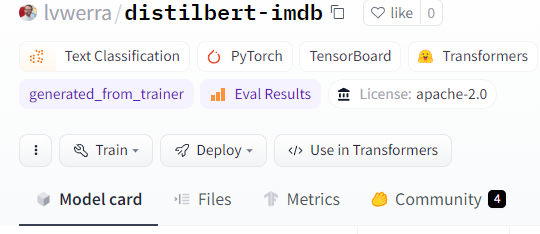

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_1 = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model_1 = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

tokenizer_2 = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model_2 = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Evaluar modelos

Se crea un pipeline por cada modelo. Los pipelines son objetos que permiten la abstracción de la mayor parte del código complejo de la biblioteca como limpieza de datos u obtención de resultados.

El primer argumento del pipeline ha de ser el tipo de tarea. Las tareas permitidas son:

- "audio-classification"
- "automatic-speech-recognition"
- "conversational"
- "feature-extraction"
- "fill-mask"
- "image-classification"
- "question-answering"
- "table-question-answering"
- "text2text-generation"
- "text-classification" (alias "sentiment-analysis" available)
- "text-generation"
- "token-classification" (alias "ner" available)
- "translation"
- "translation_xx_to_yy"
- "summarization"
- "zero-shot-classification"



In [ ]:
pipe_model1 = pipeline("text-classification", model=model_1, tokenizer=tokenizer_1, device=0) # device=0 permite ejecutarlo en GPU
pipe_model2 = pipeline("text-classification", model=model_2, tokenizer=tokenizer_2, device=0)

In [ ]:
predictions_model1 = pipe_model1(dataset[:]['text'], truncation=True) # Es posible que las longitudes de los textos sean superiores a las que admite el tokenizer
                                                                      # Se utiliza truncation=True, para truncar los datos de la misma manera que se hizo durante el entrenamiento del modelo
predictions_model2 = pipe_model2(dataset[:]['text'], truncation=True)

In [ ]:
# Las predicciones vienen como etiquetas "NEGATIVE" o "POSITIVE" y las etiquetas del dataset vienen como 0 o 1, así que hacemos un post-procesado de las predicciones
predictions_processed_model1 = []
predictions_processed_model2 = []
for pred1, pred2 in zip(predictions_model1, predictions_model2):
  predictions_processed_model1.append(0) if pred1['label']=='NEGATIVE' else predictions_processed_model1.append(1)
  predictions_processed_model2.append(0) if pred2['label']=='NEGATIVE' else predictions_processed_model2.append(1)

In [ ]:
accuracy = evaluate.load("accuracy")
# clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"]) # también es posible combinar varias métricas
accuracy_model_1 = accuracy.compute(references=dataset[:]['label'], predictions=predictions_processed_model1)
accuracy_model_2 = accuracy.compute(references=dataset[:]['label'], predictions=predictions_processed_model2)

print("Accuracy del modelo 1:", accuracy_model_1['accuracy'])
print("Accuracy del modelo 2:", accuracy_model_2['accuracy'])

Accuracy del modelo 1: 0.928
Accuracy del modelo 2: 0.89072


# Ejemplo 2 - Rellenado de huecos

## Elegir dataset

En este caso se proponen unos datos inventados

In [3]:
text = ["What time is your <mask> scheduled to take off?",
          "Do you <mask> I'm too materialistic?",
          "I think there's something <mask> with you",
          "Because of the typhoon, the school was <mask>",
          "I <mask> something burning.",
          "This <mask> has two bathrooms.",
          "How <mask> do you think she is?",
          "Does anyone here <mask> Japanese?",
          "You <mask> have done so",
          "She committed a <mask>",
          "<mask> have a cut here",
          "No, she's <mask> school",
          "Can I have a glass of water <mask>?",
          "Wait! Is this <mask>?",
          "Please refer to <mask> ten",
          "She gave him something cold to <mask>",
          "I think it's <mask> for me to talk to the boss about this problem",
          "This is a very <mask> book",
          "I have a <mask> for you",
          "Walk more <mask>",
          "Tom tried climbing the tall <mask>",
          "That blue one's <mask>",
          "<mask>, isn't it?",
          "Yes, that's <mask>",
          "I think I will take a <mask> this week",
          "Did you buy any <mask> fruit?",
          "You'd better go <mask> at once",
          "He was sitting on a <mask>"]
          
label = ["plane",
         "think",
         "wrong",
         "closed",
         "smell",
         "house",
         "old",
         "speak",
         "should",
         "crime",
         "I",
         "at",
         "please",
         "it",
         "page",
         "drink",
         "time",
         "old",
         "surprise",
         "slowly",
         "tree",
         "fine",
         "Great",
         "right",
         "vacation",
         "other",
         "home",
         "bench"]

## Elegir modelos

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer_1 = AutoTokenizer.from_pretrained("xlm-roberta-base")
model_1 = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

tokenizer_2 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model_2 = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Estos modelos predicen la palabra que iría en *mask*

OJO: la máscara puede ser distinta en cada modelo. Se puede comprobar con tokenizer.mask_token

In [ ]:
mask_model_1 = tokenizer_1.mask_token
print(mask_model_1)
mask_model_2 = tokenizer_2.mask_token
print(mask_model_2)

<mask>
[MASK]


En este caso el modelo 2 utiliza una máscara distinta a la especificada en *text* así que habría que modificar las máscaras en los textos cuando se le pasen al modelo

## Evaluar modelos

In [5]:
pipe_model1 = pipeline("fill-mask", model=model_1, tokenizer=tokenizer_1, device=0)
pipe_model2 = pipeline("fill-mask", model=model_2, tokenizer=tokenizer_2, device=0)

In [6]:
predictions_model1 = pipe_model1(text, top_k=1) # top_k controla el número de posibilidades que retorna el modelo

text_model2 = []
for sentence in text:
  text_model2.append(sentence.replace("<mask>", "[MASK]"))
predictions_model2 = pipe_model2(text_model2, top_k=1)

In [7]:
predictions_processed_model1 = []
predictions_processed_model2 = []
for pred1, pred2 in zip(predictions_model1, predictions_model2):
  predictions_processed_model1.append(pred1[0]['token_str'])
  predictions_processed_model2.append(pred2[0]['token_str'])

In [ ]:
for word, pred1, pred2 in zip(label, predictions_processed_model1, predictions_processed_model2):
  print("Palabra:", word, "\tPredicción modelo 1:", pred1, "\tPredicción modelo2:", pred2)

Palabra: plane 	Predicción modelo 1: flight 	Predicción modelo2: plane
Palabra: think 	Predicción modelo 1: think 	Predicción modelo2: think
Palabra: wrong 	Predicción modelo 1: wrong 	Predicción modelo2: wrong
Palabra: closed 	Predicción modelo 1: closed 	Predicción modelo2: closed
Palabra: smell 	Predicción modelo 1: had 	Predicción modelo2: felt
Palabra: house 	Predicción modelo 1: property 	Predicción modelo2: building
Palabra: old 	Predicción modelo 1: old 	Predicción modelo2: old
Palabra: speak 	Predicción modelo 1: speak 	Predicción modelo2: speak
Palabra: should 	Predicción modelo 1: must 	Predicción modelo2: should
Palabra: crime 	Predicción modelo 1: ... 	Predicción modelo2: suicide
Palabra: I 	Predicción modelo 1: I 	Predicción modelo2: we
Palabra: at 	Predicción modelo 1: at 	Predicción modelo2: boarding
Palabra: please 	Predicción modelo 1: too 	Predicción modelo2: tonight
Palabra: it 	Predicción modelo 1: нужно 	Predicción modelo2: happening
Palabra: page 	Predicción mode

In [26]:
def accuracy(truth, predicted):
  count = 0
  for word in predicted:
    if word in truth:
      count += 1
  return count / len(truth)

In [27]:
print("Accuracy del modelo 1:", accuracy(label, predictions_processed_model1))
print("Accuracy del modelo 2:", accuracy(label, predictions_processed_model2))

Accuracy del modelo 1: 0.35714285714285715
Accuracy del modelo 2: 0.35714285714285715
